In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer
import umap
import hdbscan
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
import joblib
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import warnings
warnings.filterwarnings('ignore')

# Setup paths
base_path = "../"
data_path = os.path.join(base_path, "data")
model_path = os.path.join(base_path, "model")
scripts_path = os.path.join(base_path, "scripts")
results_path = os.path.join(base_path, "results")

print("Setup complete. Directories created.")

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Setup complete. Directories created.


In [2]:
csv_path = os.path.join(data_path, "processed", "labeled_transcripts.csv")  # Updated path
df = pd.read_csv(csv_path)
df = df.sort_values(by=["Speech_ID", "Chunk_ID"]).reset_index(drop=True)

print(f"Loaded {len(df)} samples")
print(f"Columns: {df.columns.tolist()}")
print(f"Sample data:\n{df.head()}")

Loaded 2439 samples
Columns: ['Speech_ID', 'VideoTitle', 'Chunk_ID', 'Chunk', 'completed_percentage', 'completion_range_percentage']
Sample data:
   Speech_ID     VideoTitle Chunk_ID  \
0          1  Muniba_Mazari      1_0   
1          1  Muniba_Mazari      1_1   
2          1  Muniba_Mazari     1_10   
3          1  Muniba_Mazari     1_11   
4          1  Muniba_Mazari     1_12   

                                               Chunk  completed_percentage  \
0  Whoa. I'm running short of words right now, bu...                  0.00   
1  Well, I always start my talk with a disclaimer...                  1.89   
2  But that injury that changed me and my life co...                 18.87   
3  Many people came to rescue. They gave me CPR. ...                 20.75   
4  She's going to die. Where should we go? There ...                 22.64   

  completion_range_percentage  
0                         0-5  
1                         0-5  
2                       15-20  
3               

In [3]:
from hdbscan import approximate_predict 

class TextFeatureExtractor(BaseEstimator, TransformerMixin):
    """Extract structural features from text"""
    
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        features = []
        for text in X:
            words = text.split()
            num_words = len(words)
            num_chars = len(text)
            num_commas = text.count(',')
            num_periods = text.count('.')
            num_exclaims = text.count('!')
            num_questions = text.count('?')
            unique_words = len(set(words))
            fraction_unique_words = unique_words / (num_words + 1e-5)
            
            features.append([
                num_words, num_chars, num_commas, num_periods, 
                num_exclaims, num_questions, unique_words, fraction_unique_words
            ])
        
        return np.array(features)
    
    def get_feature_names_out(self, input_features=None):
        return ['num_words', 'num_chars', 'num_commas', 'num_periods', 
                'num_exclaims', 'num_questions', 'unique_words', 'fraction_unique_words']


class EmbeddingTransformer(BaseEstimator, TransformerMixin):
    """Generate sentence embeddings"""
    
    def __init__(self, model_name="all-mpnet-base-v2"):
        self.model_name = model_name
        self.model = None
    
    def fit(self, X, y=None):
        self.model = SentenceTransformer(self.model_name)
        return self
    
    def transform(self, X):
        if self.model is None:
            self.model = SentenceTransformer(self.model_name)
        return self.model.encode(X.tolist(), show_progress_bar=True)


class ClusteringTransformer(BaseEstimator, TransformerMixin):
    """Apply PCA, UMAP, and clustering to embeddings"""
    
    def __init__(self, n_pca_components=5, n_umap_components=2):
        self.n_pca_components = n_pca_components
        self.n_umap_components = n_umap_components
        self.pca = PCA(n_components=n_pca_components, random_state=42)
        self.umap_model = umap.UMAP(n_neighbors=15, min_dist=0.0, 
                                    n_components=n_umap_components, random_state=42)
        self.clusterer = hdbscan.HDBSCAN(min_cluster_size=5, prediction_data=True)
        
    def fit(self, X, y=None):
        pca_features = self.pca.fit_transform(X)
        umap_features = self.umap_model.fit_transform(X)
        self.clusterer.fit(umap_features)
        return self
    
    def transform(self, X):
        pca_features = self.pca.transform(X)
        umap_features = self.umap_model.transform(X)

        cluster_labels, _ = approximate_predict(self.clusterer, umap_features)
        is_noise = (cluster_labels == -1).astype(int)

        features = np.column_stack([pca_features, cluster_labels, is_noise])
        return features, cluster_labels

    def get_feature_names_out(self, input_features=None):
        pca_names = [f'pca_{i+1}' for i in range(self.n_pca_components)]
        return pca_names + ['cluster', 'is_noise']

print("Custom transformers created successfully.")


Custom transformers created successfully.


In [4]:
text_extractor = TextFeatureExtractor()
text_features = text_extractor.fit_transform(df['Chunk'])
text_feature_names = text_extractor.get_feature_names_out()
print(f"Text features shape: {text_features.shape}")

# Generate sentence embeddings
print("Generating embeddings...")
embedding_transformer = EmbeddingTransformer()
embeddings = embedding_transformer.fit_transform(df['Chunk'])
print(f"Embeddings shape: {embeddings.shape}")

# Apply clustering transformations (fixed: separate fit and transform)
print("Applying clustering transformations...")
clustering_transformer = ClusteringTransformer()
clustering_transformer.fit(embeddings) 
clustering_features, cluster_labels = clustering_transformer.transform(embeddings) 
clustering_feature_names = clustering_transformer.get_feature_names_out()
print(f"Clustering features shape: {clustering_features.shape}")

Text features shape: (2439, 8)
Generating embeddings...


Batches: 100%|██████████████████████████████████| 77/77 [00:57<00:00,  1.34it/s]


Embeddings shape: (2439, 768)
Applying clustering transformations...
Clustering features shape: (2439, 7)


In [5]:
def compute_temporal_features(df, cluster_labels):
    """Compute temporal cluster features"""
    df_temp = df.copy()
    df_temp['cluster'] = cluster_labels
    
    cluster_progress = []
    fraction_unique_clusters = []
    
    for _, group in df_temp.groupby("Speech_ID"):
        seen = set()
        total_clusters = set(group['cluster'].unique())
        cluster_seen = []
        frac_unique = []
        
        for c in group['cluster']:
            cluster_seen.append(int(c in seen))
            seen.add(c)
            frac_unique.append(len(seen) / len(total_clusters))
        
        cluster_progress.extend(cluster_seen)
        fraction_unique_clusters.extend(frac_unique)
    
    return np.array(cluster_progress), np.array(fraction_unique_clusters)

# Compute temporal features
cluster_seen_before, fraction_unique_clusters = compute_temporal_features(df, cluster_labels)

print("Temporal features computed successfully.")

Temporal features computed successfully.


In [6]:
class SpeechCompletionPredictor(BaseEstimator):
    """Single unified model for speech completion prediction"""

    def __init__(self):
        self.text_extractor = TextFeatureExtractor()
        self.embedding_transformer = EmbeddingTransformer()
        self.clustering_transformer = ClusteringTransformer()
        self.lgb_model = lgb.LGBMRegressor(n_estimators=1000, learning_rate=0.01, random_state=42)
        self.feature_names = None
        self.is_fitted = False

    def _compute_temporal_features(self, df_temp, cluster_labels):
        """Compute temporal cluster features"""
        cluster_progress = []
        fraction_unique_clusters = []

        for _, group in df_temp.groupby("Speech_ID"):
            seen = set()
            total_clusters = set(group['cluster'].unique())
            cluster_seen = []
            frac_unique = []

            for c in group['cluster']:
                cluster_seen.append(int(c in seen))
                seen.add(c)
                frac_unique.append(len(seen) / len(total_clusters))

            cluster_progress.extend(cluster_seen)
            fraction_unique_clusters.extend(frac_unique)

        return np.array(cluster_progress), np.array(fraction_unique_clusters)

    def _prepare_features(self, X_df):
        """Prepare all features for training/prediction"""
        text_features = self.text_extractor.transform(X_df['Chunk'])
        embeddings = self.embedding_transformer.transform(X_df['Chunk'])
        clustering_features, cluster_labels = self.clustering_transformer.transform(embeddings)

        df_temp = X_df.copy()
        df_temp['cluster'] = cluster_labels
        cluster_seen, frac_unique = self._compute_temporal_features(df_temp, cluster_labels)

        all_features = np.column_stack([
            text_features,
            clustering_features,
            cluster_seen.reshape(-1, 1),
            frac_unique.reshape(-1, 1)
        ])

        return all_features

    def fit(self, X_df, y, eval_set=None):
        """Fit the complete model"""
        text_features = self.text_extractor.fit_transform(X_df['Chunk'])
        embeddings = self.embedding_transformer.fit_transform(X_df['Chunk'])
        clustering_features, cluster_labels = self.clustering_transformer.fit_transform(embeddings)

        df_temp = X_df.copy()
        df_temp['cluster'] = cluster_labels
        cluster_seen, frac_unique = self._compute_temporal_features(df_temp, cluster_labels)

        all_features = np.column_stack([
            text_features,
            clustering_features,
            cluster_seen.reshape(-1, 1),
            frac_unique.reshape(-1, 1)
        ])

        self.feature_names = (
            self.text_extractor.get_feature_names_out() +
            self.clustering_transformer.get_feature_names_out() +
            ['cluster_seen_before', 'fraction_unique_clusters']
        )


        if eval_set is not None:
            X_val_df, y_val = eval_set
            val_features = self._prepare_features(X_val_df)
            eval_set_processed = [(val_features, y_val)]

            self.lgb_model.fit(
                all_features, y,
                eval_set=eval_set_processed,
                eval_metric='mae',
                callbacks=[early_stopping(stopping_rounds=50), log_evaluation(50)]
            )
        else:
            self.lgb_model.fit(all_features, y)

        self.is_fitted = True
        return self

    def predict(self, X_df):
        """Make predictions"""
        if not self.is_fitted:
            raise ValueError("Model must be fitted before making predictions")

        features = self._prepare_features(X_df)
        return self.lgb_model.predict(features)

    def get_feature_importance(self):
        """Get feature importance"""
        if not self.is_fitted:
            raise ValueError("Model must be fitted before getting feature importance")

        importance_df = pd.DataFrame({
            'feature': self.feature_names,
            'importance': self.lgb_model.feature_importances_ / self.lgb_model.feature_importances_.sum()
        }).sort_values(by='importance', ascending=False)

        return importance_df

print("Single unified model class created successfully.")

Single unified model class created successfully.


In [7]:
# Prepare data for training
X_train, X_test, y_train, y_test = train_test_split(
    df[['Speech_ID', 'Chunk_ID', 'Chunk']], 
    df['completed_percentage'], 
    test_size=0.2, 
    random_state=42
)

print(f"Training set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")

# Create and train the single model
print("\nTraining the unified model...")
speech_model = SpeechCompletionPredictor()
speech_model.fit(X_train, y_train, eval_set=(X_test, y_test))

print("\nModel training completed")

Training set: 1951 samples
Test set: 488 samples

Training the unified model...


Batches: 100%|██████████████████████████████████| 16/16 [00:11<00:00,  1.36it/s]
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000645 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2252
[LightGBM] [Info] Number of data points in the train set: 1951, number of used features: 17
[LightGBM] [Info] Start training from score 47.761184
Training until validation scores don't improve for 50 rounds
[50]	valid_0's l1: 24.7327	valid_0's l2: 813.956
[100]	valid_0's l1: 24.4945	valid_0's l2: 801.839
[150]	valid_0's l1: 24.3429	valid_0's l2: 795.201
[200]	valid_0's l1: 24.2132	valid_0's l2: 790.754
Early stopping, best iteration is:
[186]	valid_0's l1: 24.2065	valid_0's l2: 789.547

Model training completed


In [8]:
y_train_pred = speech_model.predict(X_train)
y_test_pred = speech_model.predict(X_test)

# Calculate metrics
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"\nModel Performance:")
print(f"Training MAE: {train_mae:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Training R²: {train_r2:.4f}")
print(f"Test R²: {test_r2:.4f}")

Batches: 100%|██████████████████████████████████| 16/16 [00:10<00:00,  1.47it/s]



Model Performance:
Training MAE: 20.2074
Test MAE: 24.2065
Training R²: 0.3359
Test R²: 0.0588



Top 10 Most Important Features:
                     feature  importance
12                     pca_5    0.131720
9                      pca_2    0.125986
11                     pca_4    0.119534
8                      pca_1    0.096057
13                   cluster    0.084767
10                     pca_3    0.079211
1                  num_chars    0.065233
16  fraction_unique_clusters    0.062724
7      fraction_unique_words    0.061470
0                  num_words    0.055018


<function matplotlib.pyplot.show(close=None, block=None)>

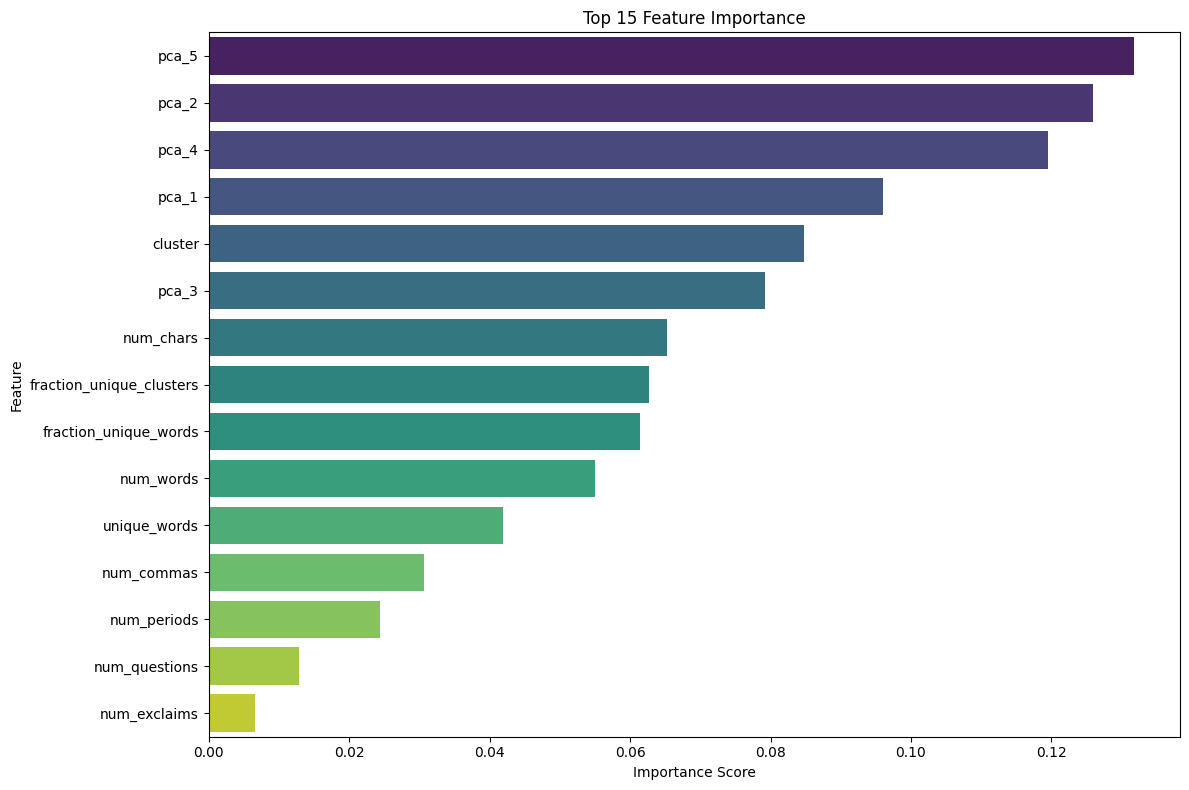

In [9]:
feature_importance = speech_model.get_feature_importance()

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(data=feature_importance.head(15), x='importance', y='feature', palette='viridis')
plt.title("Top 15 Feature Importance")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.savefig(os.path.join(results_path, 'feature_importance.png'), dpi=300, bbox_inches='tight')
plt.show

In [10]:
# Save the complete model
model_filename = os.path.join(model_path, 'speech_completion_clustering_model.pkl')
joblib.dump(speech_model, model_filename)

# Save model metadata
model_metadata = {
    'model_type': 'SpeechCompletionPredictor',
    'training_samples': len(X_train),
    'test_samples': len(X_test),
    'features': speech_model.feature_names,
    'performance': {
        'train_mae': train_mae,
        'test_mae': test_mae,
        'train_r2': train_r2,
        'test_r2': test_r2
    },
    'feature_importance': feature_importance.to_dict('records')
}

metadata_filename = os.path.join(model_path, 'model_metadata.pkl')
joblib.dump(model_metadata, metadata_filename)

# Save feature importance as CSV
feature_importance.to_csv(os.path.join(results_path, 'feature_importance.csv'), index=False)

print(f"\n=== MODEL SAVING COMPLETE ===")
print(f"Model saved to: {model_filename}")
print(f"Metadata saved to: {metadata_filename}")
print(f"Feature importance saved to: {os.path.join(results_path, 'feature_importance.csv')}")
print(f"\nFinal Model Performance:")
print(f"Test MAE: {test_mae:.4f}")
print(f"Test R²: {test_r2:.4f}")
print(f"Number of features: {len(speech_model.feature_names)}")


=== MODEL SAVING COMPLETE ===
Model saved to: ../model/speech_completion_clustering_model.pkl
Metadata saved to: ../model/model_metadata.pkl
Feature importance saved to: ../results/feature_importance.csv

Final Model Performance:
Test MAE: 24.2065
Test R²: 0.0588
Number of features: 17
